In [1]:
import jax

jax.config.update("jax_platform_name", "cpu")
import numpyro

numpyro.set_host_device_count(4)

import arviz as az
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt

from pymc_experimental.statespace import structural as st

import utils.globalsettings as gs
from utils.sts.simul import stochastic_trend, make_fourier_features

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [8, 5] # 12, 7
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Ignore warnings about Deprecated
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

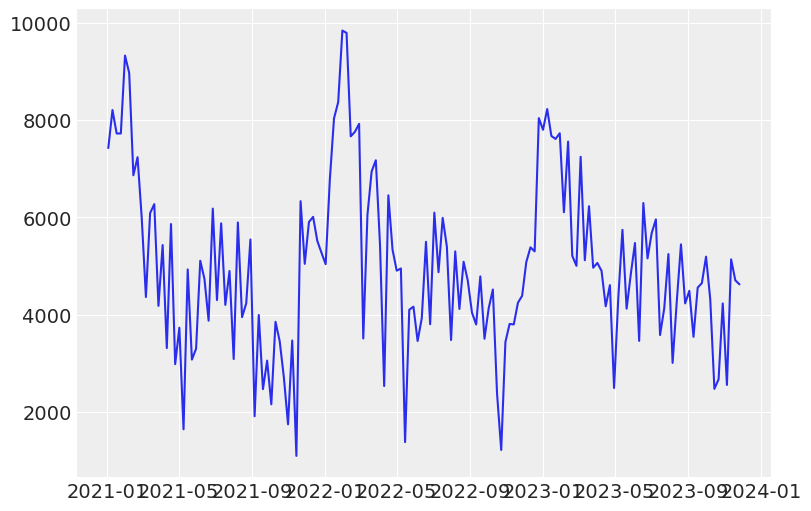

In [3]:
RANDOM_SEED = 11111
rng = np.random.default_rng(RANDOM_SEED)

df = pd.DataFrame(
    {
        "fecha": pd.date_range(start="2021-01-01", end="2023-11-30", freq="W")
    }
)

# df = pd.DataFrame(index=pd.date_range(start="2021-01-01", end="2023-11-30", freq="W"))

df = pd.concat([
    df, 
    stochastic_trend(
        rng, 
        N = df.shape[0], 
        sigma_local_trend = 1, 
        local_trend_0 = 1, 
        sigma_local_level = 1, 
        local_level_0 = 5000
        )
    ], 
    axis = 1)

fourier_features = make_fourier_features(df, "fecha", n_order=2, period=365.25/7)
fourier_coefs = np.array(fourier_features.shape[1]*[1.0])

df['yr_season'] = 1000 * np.dot(fourier_features, fourier_coefs)

df['y'] = df['local_level'] + df['yr_season'] + rng.normal(0, 1000, df.shape[0])
df.set_index('fecha', inplace=True)
df.index = pd.date_range(start=df.index[0], end=df.index[-1], freq='W')

plt.plot(df.index, df['y'])

In [4]:
df

,t,local_trend,local_level,yr_season,y
2021-01-03,1,-0.521628,4999.953346,2088.006727,7427.308697
2021-01-10,2,-1.095988,4999.356985,2390.190343,8210.172303
2021-01-17,3,-3.458094,4995.523637,2603.642657,7726.687269
2021-01-24,4,-3.890317,4994.106529,2720.042904,7727.444572
2021-01-31,5,-4.609461,4989.303431,2735.901315,9331.541874
...,...,...,...,...,...
2023-10-29,148,2.821919,4987.733155,-1866.019942,4227.889182
2023-11-05,149,2.217268,4987.813049,-1621.248183,2550.183863
2023-11-12,150,1.635618,4990.604350,-1295.783105,5135.684591
2023-11-19,151,1.679701,4992.060263,-901.137075,4704.377551


In [5]:
y = df["y"].to_numpy()
y_max = np.max(y)
y_min = np.min(y)
y = y / y_max

t = df['t']
t_min = np.min(t)
t_max = np.max(t)
t = (t - t_min) / (t_max - t_min)

df_scale = pd.DataFrame({'y': y, 't': t})

In [107]:
df_scale

,y,t
2021-01-03,0.754393,0.000000
2021-01-10,0.833908,0.006623
2021-01-17,0.784801,0.013245
2021-01-24,0.784877,0.019868
2021-01-31,0.947806,0.026490
...,...,...
2023-10-29,0.429427,0.973510
2023-11-05,0.259022,0.980132
2023-11-12,0.521632,0.986755
2023-11-19,0.477824,0.993377


In [6]:
y.shape

(152,)

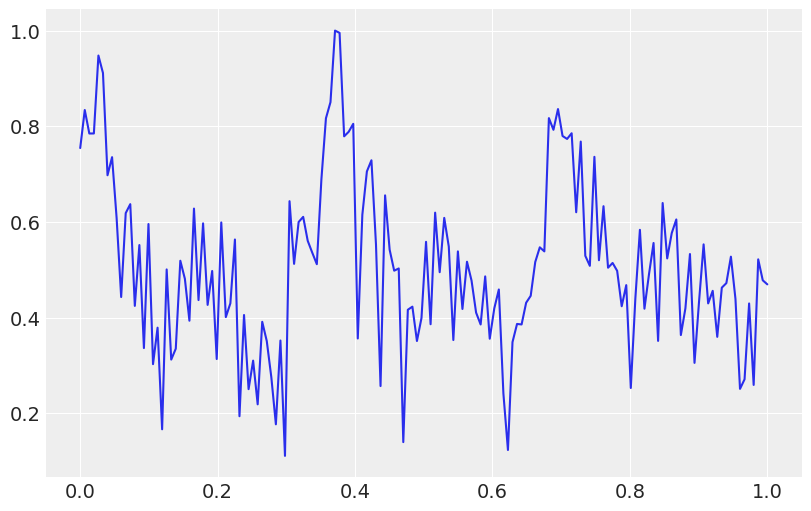

In [7]:
plt.plot(t, y)

In [8]:
ll = st.LevelTrendComponent(order=2) # Local level + local trend
se = st.FrequencySeasonality(season_length=52.25, n = 2, name="annual")

mod = ll + se
ss_mod = mod.build()

The following parameters should be assigned priors inside a PyMC model block: 
	initial_trend -- shape: (2,), constraints: None, dims: ('trend_state',)
	sigma_trend -- shape: (2,), constraints: Positive, dims: ('trend_shock',)
	annual -- shape: (4,), constraints: None, dims: (annual_initial_state, )
	sigma_annual -- shape: (1,), constraints: Positive, dims: None
	P0 -- shape: (6, 6), constraints: Positive semi-definite, dims: ('state', 'state_aux')


In [9]:
ss_mod.param_dims

{'initial_trend': ('trend_state',),
 'sigma_trend': ('trend_shock',),
 'annual': ('annual_initial_state',),
 'P0': ('state', 'state_aux')}

In [10]:
initial_trend_dims, sigma_trend_dims, annual_dims, P0_dims = ss_mod.param_dims.values()
coords = ss_mod.coords

In [81]:
annual_dims

('annual_initial_state',)

In [11]:
coords

{'trend_state': ['level', 'trend'],
 'trend_shock': ['level', 'trend'],
 'annual_initial_state': ['annual_Cos_0',
  'annual_Sin_0',
  'annual_Cos_1',
  'annual_Sin_1'],
 'state': ['level',
  'trend',
  'annual_Cos_0',
  'annual_Sin_0',
  'annual_Cos_1',
  'annual_Sin_1'],
 'state_aux': ['level',
  'trend',
  'annual_Cos_0',
  'annual_Sin_0',
  'annual_Cos_1',
  'annual_Sin_1'],
 'observed_state': ['data'],
 'observed_state_aux': ['data'],
 'shock': ['level',
  'trend',
  'annual_Cos_0',
  'annual_Sin_0',
  'annual_Cos_1',
  'annual_Sin_1'],
 'shock_aux': ['level',
  'trend',
  'annual_Cos_0',
  'annual_Sin_0',
  'annual_Cos_1',
  'annual_Sin_1']}

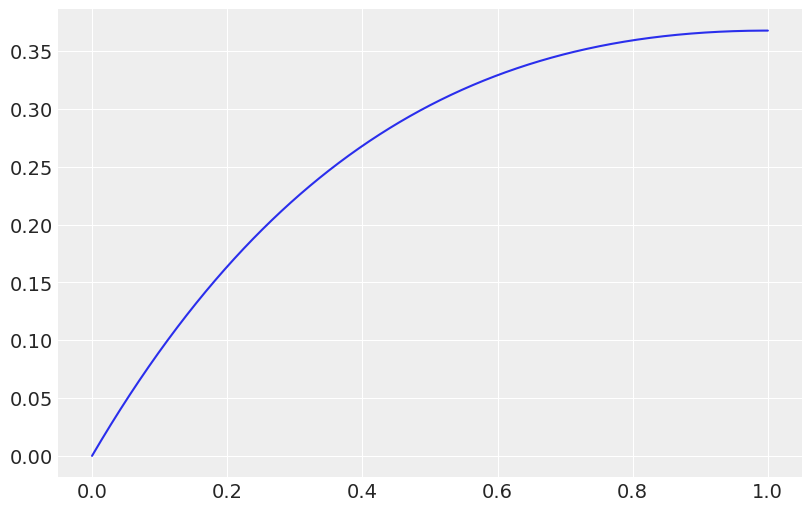

In [103]:
from scipy.stats import gamma
x = np.linspace(0, 1, 1000)
y = gamma.pdf(x, a=2, scale=1)

plt.plot(x, y)

In [106]:
gamma.rvs(a=2, scale=1, size=100000).mean()

2.002965960286446

In [108]:
with pm.Model(coords=coords) as model__trend_season:
    P0_diag = pm.Gamma("P0_diag", alpha=2, beta=1, dims=P0_dims[0])
    P0 = pm.Deterministic("P0", pt.diag(P0_diag), dims=P0_dims)
    initial_trend = pm.Normal("initial_trend", sigma=[1, 1], dims=initial_trend_dims)
    annual_seasonal = pm.Normal("annual", sigma=1, dims=annual_dims)

    sigma_trend = pm.Gamma("sigma_trend", alpha=2, beta=1, dims=sigma_trend_dims)
    sigma_monthly_season = pm.Gamma("sigma_annual", alpha=2, beta=1)
    sigma_ar = pm.Gamma("sigma_ar", alpha=2, beta=1)

    ss_mod.build_statespace_graph(df_scale['y'], mode="JAX")

In [109]:
with model__trend_season:   
    prior_pc = pm.sample_prior_predictive()

Sampling: [P0_diag, annual, initial_trend, obs, sigma_annual, sigma_ar, sigma_trend]


In [110]:
prior_pc

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data
	> constant_data

Text(0.5, 1.0, 'Prior predictive')

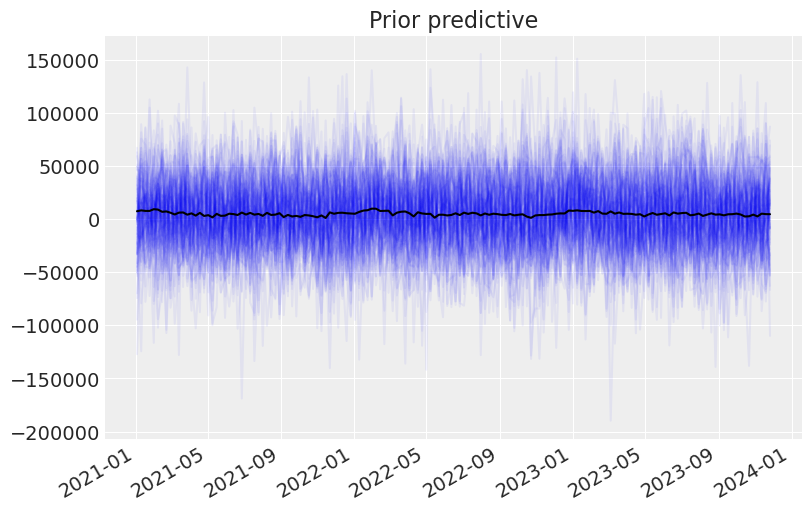

In [111]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True)

ax.plot(
    df.index,
    az.extract(prior_pc, group="prior_predictive", num_samples=100)["obs"][:,0,:]* y_max,
    color="blue",
    alpha=0.05,
)
df.y.plot(color="k", ax=ax)
ax.set_title("Prior predictive")

In [ ]:
c_prior_pc = ss_mod.sample_conditional_prior(prior_pc)
c_prior_pc

c:\Users\migue\anaconda3\envs\pymc_env\Lib\site-packages\pytensor\link\jax\linker.py:28: UserWarning: The RandomType SharedVariables [RandomGeneratorSharedVariable(<Generator(PCG64) at 0x26AD3B75C40>), RandomGeneratorSharedVariable(<Generator(PCG64) at 0x26A348D6180>), RandomGeneratorSharedVariable(<Generator(PCG64) at 0x26AD3B77AE0>), RandomGeneratorSharedVariable(<Generator(PCG64) at 0x26A5495AA40>), RandomGeneratorSharedVariable(<Generator(PCG64) at 0x26AD3B76340>), RandomGeneratorSharedVariable(<Generator(PCG64) at 0x26AD3B75A80>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
Sampling: [filtered_prior, filtered_prior_observed, predicted_prior, predicted_prior_observed, smoothed_prior, smoothed_prior_observed]


<xarray.Dataset>
Dimensions:                   (chain: 1, draw: 500, time: 152, state: 6,
                               observed_state: 1)
Coordinates:
  * chain                     (chain) int32 0
  * draw                      (draw) int32 0 1 2 3 4 5 ... 495 496 497 498 499
  * time                      (time) datetime64[ns] 2021-01-03 ... 2023-11-26
  * state                     (state) <U12 'level' 'trend' ... 'annual_Sin_1'
  * observed_state            (observed_state) <U4 'data'
Data variables:
    filtered_prior            (chain, draw, time, state) float64 -1.23 ... -0...
    filtered_prior_observed   (chain, draw, time, observed_state) float64 0.7...
    predicted_prior           (chain, draw, time, state) float64 2.844 ... -1...
    predicted_prior_observed  (chain, draw, time, observed_state) float64 2.0...
    smoothed_prior            (chain, draw, time, state) float64 0.1641 ... -...
    smoothed_prior_observed   (chain, draw, time, observed_state) float64 0.7...
Attributes:
    created_at:                 2023-12-16T07:38:07.144975
    arviz_version:              0.16.1
    inference_library:          pymc
    inference_library_version:  5.10.0

c:\Users\migue\anaconda3\envs\pymc_env\Lib\site-packages\arviz\data\inference_data.py:153: UserWarning: predicted_prior_obs group is not defined in the InferenceData scheme
  warnings.warn(


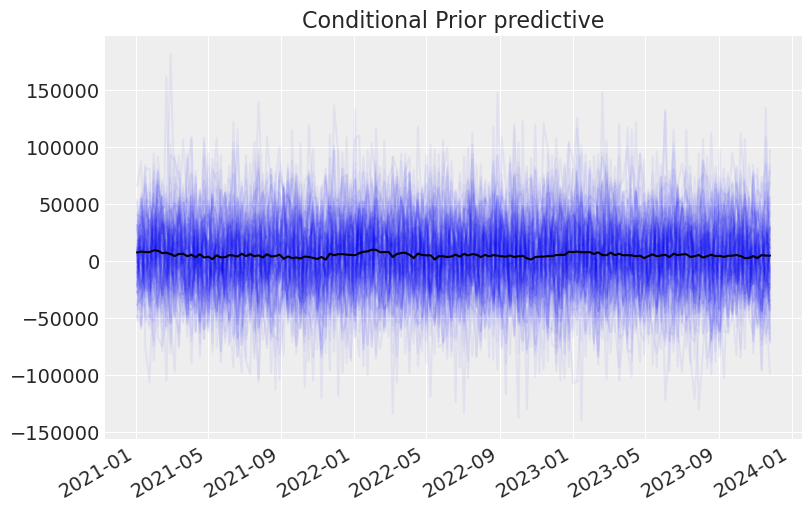

In [157]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True)

ax.plot(
    df.index,
    az.extract(c_prior_pc['predicted_prior_observed'], group="predicted_prior_obs", num_samples=100).to_array()[0,:,0,:] * y_max,
    color="blue",
    alpha=0.05,
)
df.y.plot(color="k", ax=ax)
ax.set_title("Conditional Prior predictive");

In [ ]:
uc_prior_pc = ss_mod.sample_unconditional_prior(prior_pc)
uc_prior_pc

c:\Users\migue\anaconda3\envs\pymc_env\Lib\site-packages\pytensor\link\jax\linker.py:28: UserWarning: The RandomType SharedVariables [RandomGeneratorSharedVariable(<Generator(PCG64) at 0x26A44755000>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
Sampling: [prior_combined]


<xarray.Dataset>
Dimensions:         (chain: 1, draw: 500, time: 152, state: 6, observed_state: 1)
Coordinates:
  * chain           (chain) int32 0
  * draw            (draw) int32 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
  * time            (time) datetime64[ns] 2021-01-03 2021-01-10 ... 2023-11-26
  * state           (state) <U12 'level' 'trend' ... 'annual_Sin_1'
  * observed_state  (observed_state) <U4 'data'
Data variables:
    prior_latent    (chain, draw, time, state) float64 3.233 -0.2491 ... -11.18
    prior_observed  (chain, draw, time, observed_state) float64 5.278 ... -185.7
Attributes:
    created_at:                 2023-12-16T07:38:35.057739
    arviz_version:              0.16.1
    inference_library:          pymc
    inference_library_version:  5.10.0

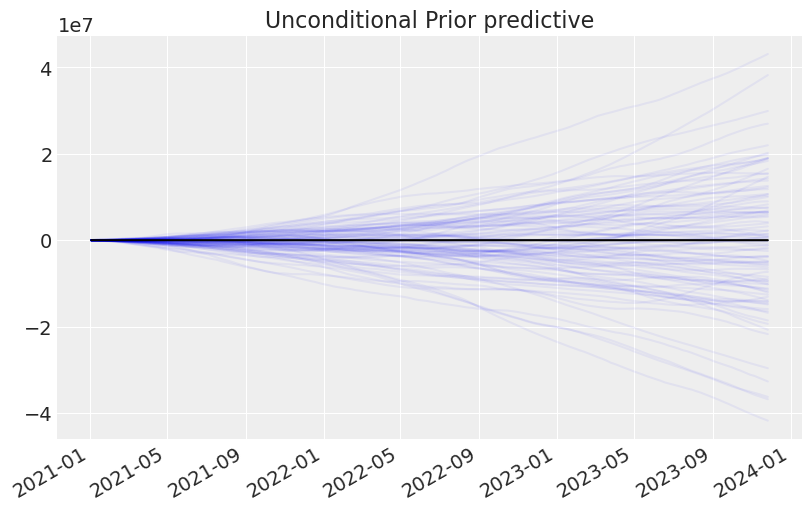

In [158]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True)

ax.plot(
    df.index,
    az.extract(uc_prior_pc['prior_observed'], num_samples=100).to_array()[0,:,0,:] * y_max,
    color="blue",
    alpha=0.05,
)
df.y.plot(color="k", ax=ax)
ax.set_title("Unconditional Prior predictive");

In [44]:
with model__trend_season:
    idata = pm.sample(
        draws=10000,
        chains=4,
        nuts_sampler="numpyro"
        )

Compiling...
Compilation time = 0:00:12.655588
Sampling...


  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

Sampling time = 0:05:59.551520
Transforming variables...
Transformation time = 0:02:34.434114


In [33]:
posterior_pc = ss_mod.sample_conditional_posterior(idata)

c:\Users\migue\anaconda3\envs\pymc_env\Lib\site-packages\pytensor\link\jax\linker.py:28: UserWarning: The RandomType SharedVariables [RandomGeneratorSharedVariable(<Generator(PCG64) at 0x26A4D5A97E0>), RandomGeneratorSharedVariable(<Generator(PCG64) at 0x26A4D5A8740>), RandomGeneratorSharedVariable(<Generator(PCG64) at 0x26A4D5A9700>), RandomGeneratorSharedVariable(<Generator(PCG64) at 0x26A4D5A8E40>), RandomGeneratorSharedVariable(<Generator(PCG64) at 0x26A4D5A9D20>), RandomGeneratorSharedVariable(<Generator(PCG64) at 0x26A4D5A8F20>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
Sampling: [filtered_posterior, filtered_posterior_observed, predicted_posterior, predicted_posterior_observed, smoothed_posterior, smoothed_posterior_observed]


c:\Users\migue\anaconda3\envs\pymc_env\Lib\site-packages\arviz\stats\density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


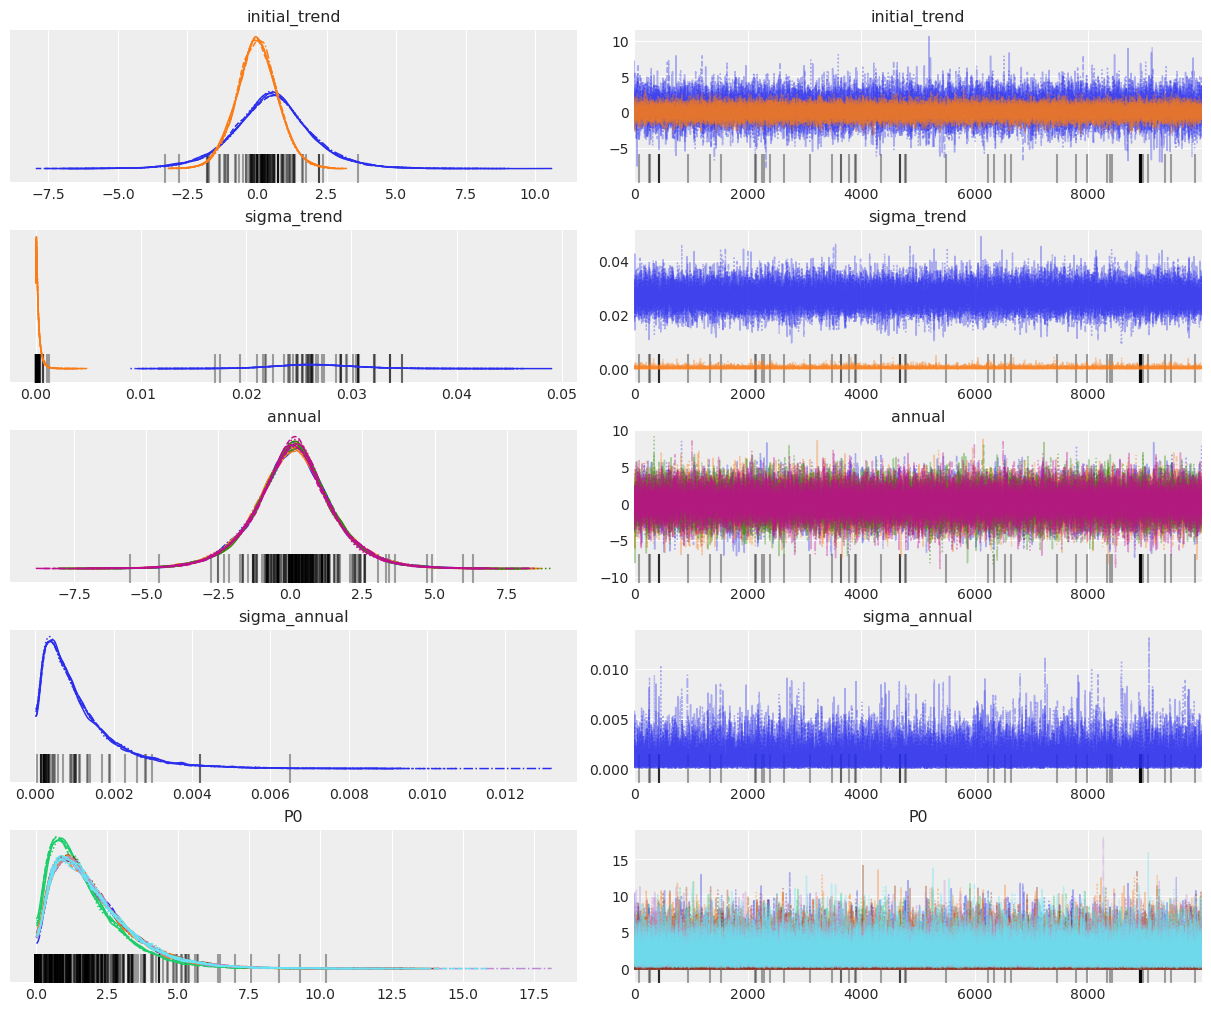

In [34]:
az.plot_trace(idata, var_names=ss_mod.param_names);

In [35]:
component_idata = ss_mod.extract_components_from_idata(posterior_pc)
component_states = component_idata.coords["state"].values.tolist()
component_states

Variables filtered_posterior_observed, predicted_posterior_observed, smoothed_posterior_observed do not contain all hidden states (their last dimension is not 6). They will not be present in the modified idata.


['LevelTrend[level]', 'LevelTrend[trend]', 'annual']

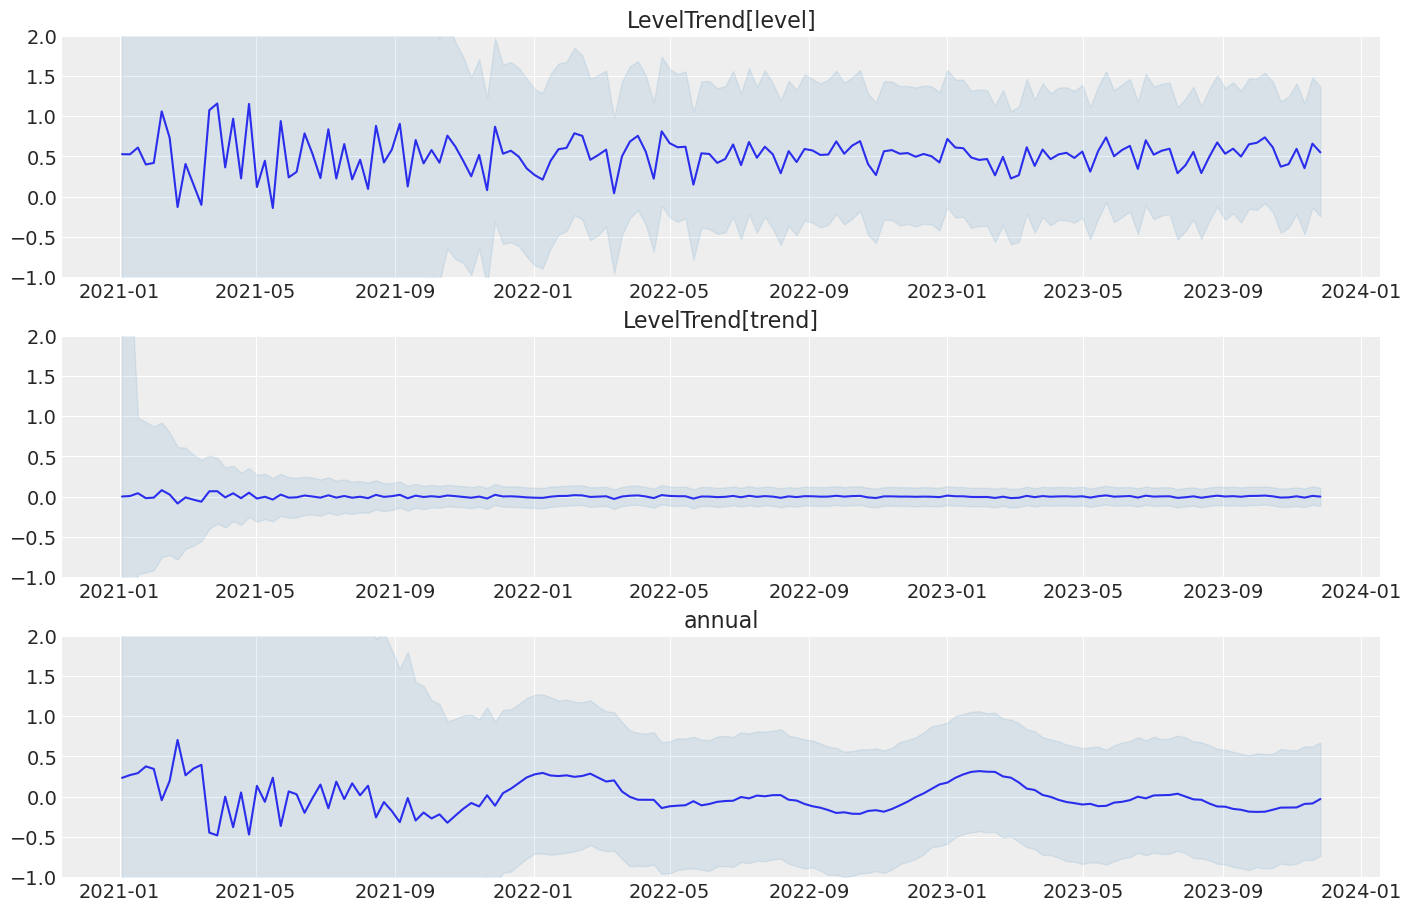

In [49]:
fig, ax = plt.subplots(3, 1, figsize=(14, 9))
x_values = component_idata.coords["time"]
for axis, name in zip(fig.axes, component_states):
    data = component_idata.predicted_posterior.sel(state=name)
    hdi = az.hdi(data).predicted_posterior
    mean = data.mean(dim=["chain", "draw"])

    axis.plot(x_values, mean)
    axis.fill_between(x_values, *hdi.values.T, color="tab:blue", alpha=0.1)
    axis.set_title(name)
    axis.set_ylim([-1, 2])
plt.show()

In [1]:
fig, ax = plt.subplots()
post_stacked = posterior_pc.stack(sample=["chain", "draw"])
x_values = post_stacked.coords["time"]
hdi_post = az.hdi(posterior_pc)
post_stacked = posterior_pc.stack(sample=["chain", "draw"])

ax.plot(
    x_values,
    post_stacked.predicted_posterior.sum(dim="state").mean(dim="sample"),
)
ax.fill_between(x_values, *hdi_post.predicted_posterior.sum(dim="state").values.T, alpha=0.25)
ax.plot(df_scale.index, df_scale.y)

# Fix y axis between 0 and 1
ax.set_ylim([-1, 2])

NameError: name 'plt' is not defined

In [30]:
forecasts = ss_mod.forecast(idata, start=df_scale.index[-1], periods=24)
forecasts = forecasts.stack(sample=["chain", "draw"])

c:\Users\migue\anaconda3\envs\pymc_env\Lib\site-packages\pytensor\link\jax\linker.py:28: UserWarning: The RandomType SharedVariables [RandomGeneratorSharedVariable(<Generator(PCG64) at 0x26A310217E0>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
Sampling: [forecast_combined]


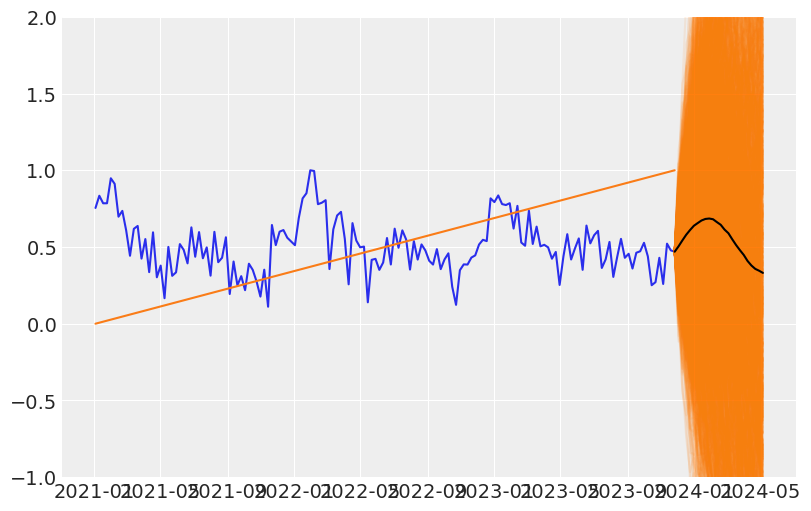

In [42]:
fig, ax = plt.subplots()
ax.plot(df_scale.index, df_scale)
ax.plot(
    forecasts.coords["time"],
    forecasts.forecast_observed.values.squeeze(),
    color="tab:orange",
    alpha=0.1,
)
ax.plot(
    forecasts.coords["time"],
    forecasts.forecast_observed.mean(dim="sample").values.squeeze(),
    color="k",
    alpha=1,
)
ax.set_ylim([-1, 2])
plt.show()